In [1]:
from tqdm import tqdm
from qiskit import quantum_info
import matplotlib.pyplot as plt
import numpy as np
from qiskit.providers.aer import AerSimulator
from qiskit import Aer, execute
from qiskit.providers.fake_provider import FakeParis
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from scipy import *
basis_gates=['cx', 'id', 'rz', 'x', 'sx']

In [2]:
def fnu0(a, g):
    
       return ((1/np.cosh(g/2))**(4)*((a**(2) + 4)*np.cosh(g)+a**(2) + 2))/(2*a**2)

def fnu1(a, g): 
    
    return ((1/np.cosh(g/2))**(4))/(a**2)-2/(np.cosh(g)+1)
    

def fmu0(a, g): 
    
    return (((1/np.cosh(g/2))**(4))/((a**(4))*(np.cosh(g)+1)))*(8*(a**(2)+2)*np.cosh(g)-((a**(2)*(1/np.cosh(g/2))**(8))/(64))*(433-1688*np.cosh(g)+372*np.cosh(2*g)-168*np.cosh(3*g)+8*np.sqrt(2)*np.sqrt(np.cosh(g)+1)*(59*np.cosh(g/2)+33*np.cosh(3*g/2)+3*np.cosh(5*g/2)+np.cosh(7*g/2))+27*np.cosh(4*g)))
    

def fmu1(a, g):
    
    return -(((1/np.cosh(g/2))**(14))/(128*a**(4)))*(-1024*np.cosh(g/2)**(8)+513*np.sqrt(2)*(a**2)*np.cosh(g/2)*np.sqrt(np.cosh(g)+1)+(a**2)*(-1405+610*np.cosh(g)-877*np.cosh(2*g)+157*np.cosh(3*g)-22*np.cosh(4*g)+np.sqrt(2)*np.sqrt(np.cosh(g)+1)*(193*np.cosh(3*g/2)+60*np.cosh(5*g/2)+np.cosh(7*g/2)+np.cosh(9*g/2))+np.cosh(5*g)))

def fmu2(a, g):
    
    return (((1/np.cosh(g/2))**(12))*(np.tanh(g/2)**(2))/(64*a**2))*(-198+219*np.cosh(g)-34*np.cosh(2*g)+31*np.cosh(3*g)+2*np.sqrt(2)*np.sqrt(np.cosh(g)+1)*(8*np.cosh(g/2)-13*np.cosh(3*g/2)+np.cosh(5*g/2)-np.cosh(7*g/2))+2*np.cosh(4*g))

def fmu3(a, g):
    
    return -((np.tanh(g/2)**(4))*((1/np.cosh(g/2))**(10))/(2*a**2))*(+22-12*np.cosh(g)+6*np.cosh(2*g)+4*np.sqrt(2)*np.sinh(g/2)**(2)*np.cosh(g/2)*np.sqrt(np.cosh(g)+1)) 

def fmu4(a, g):
    
    return ((np.tanh(g/2)**(4))*((1/np.cosh(g/2))**(10))/(8*a**2))*(15*(np.cosh(2*g)+3)-44*np.cosh(g))

def fmu5(a, g):
    
    return -((4*np.tanh(g/2)**(8))*((1/np.cosh(g/2))**(6)))/(a**2)

def fmu6(a, g):
    
    return (8192*np.sinh(g/2)**(22)*(1/np.sinh(g))**(14))/(a**2)

In [5]:
print("nu0=",nu0(1,0.3))
print("nu1=",nu1(1,0.3))
print("mu0=",mu0(1,0.3))
print("mu1=",mu1(1,0.3))
print("mu2=",mu2(1,0.3))
print("mu3=",mu3(1,0.3))
print("mu4=",mu4(1,0.3))
print("mu5=",mu5(1,0.3))
print("mu6=",mu6(1,0.3))

NameError: name 'nu0' is not defined

In [17]:
def dispersionplus(k,a,g):
    
    nu0=fnu0(a,g)
    nu1=fnu1(a,g)
    mu0=fmu0(a,g)
    mu1=fmu1(a,g)
    mu2=fmu2(a,g)
    mu3=fmu3(a,g)
    mu4=fmu4(a,g)
    mu5=fmu5(a,g)
    mu6=fmu6(a,g)
    
    return (1/np.sqrt(2))*np.sqrt(nu0+nu1*np.cos(2*k)+np.sqrt(mu0+mu1*np.cos(2*k)+mu2*np.cos(4*k)+mu3*np.cos(6*k)+mu4*np.cos(8*k)+mu5*np.cos(10*k)+mu6*np.cos(12*k)))
    

In [18]:
def dispersionmin(k,a,g):
    
    nu0=fnu0(a,g)
    nu1=fnu1(a,g)
    mu0=fmu0(a,g)
    mu1=fmu1(a,g)
    mu2=fmu2(a,g)
    mu3=fmu3(a,g)
    mu4=fmu4(a,g)
    mu5=fmu5(a,g)
    mu6=fmu6(a,g)
    
    return (1/np.sqrt(2))*np.sqrt(nu0+nu1*np.cos(2*k)-np.sqrt(mu0+mu1*np.cos(2*k)+mu2*np.cos(4*k)+mu3*np.cos(6*k)+mu4*np.cos(8*k)+mu5*np.cos(10*k)+mu6*np.cos(12*k)))
    

/tmp/ipykernel_151/1313732988.py:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


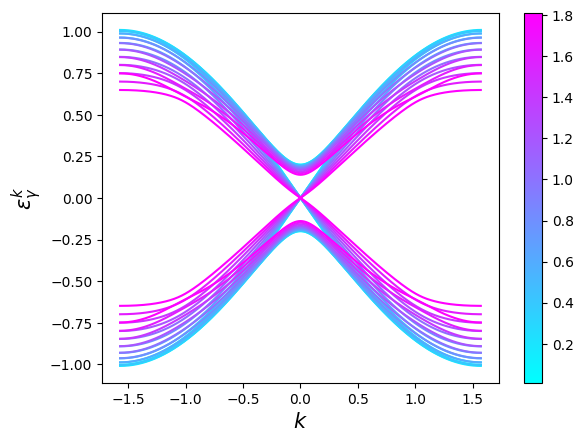

In [16]:
from itertools import cycle
from matplotlib.colors import Normalize
csfont = {'fontname':'Serif'}
colormap1 = plt.cm.cool
k_range = np.arange(-np.pi/2,np.pi/2,0.001)

gamma_range=np.arange(0.01,2,0.2)
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(gamma_range))))
a=10


for _,g in enumerate(gamma_range):
    color1 = next(color_cycle1)
    plt.plot(k_range,dispersionplus(k_range,a,g),c=color1)
    plt.plot(k_range,-dispersionplus(k_range,a,g),c=color1)
    plt.plot(k_range,dispersionmin(k_range,a,g),c=color1)
    plt.plot(k_range,-dispersionmin(k_range,a,g),c=color1)
    
    
sm = plt.cm.ScalarMappable(cmap=colormap1, norm=Normalize(vmin=gamma_range.min(), vmax=gamma_range.max()))
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm)
#plt.colorbar(gamma_range)
#plt.xlim(0,np.pi/2)
plt.xlabel(r'$k$',**csfont, size='15')
plt.ylabel(r'$\epsilon_{\gamma}^{k}$',**csfont, size='15')
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/Dispersion Hgamma A=10.pdf", bbox_inches='tight')  

In [274]:
(np.sqrt(2)).shape

()

/tmp/ipykernel_151/3992559410.py:13: RuntimeWarning: invalid value encountered in sqrt
  return (1/np.sqrt(2))*np.sqrt(nu0+nu1*np.cos(2*k)+np.sqrt(mu0+mu1*np.cos(2*k)+mu2*np.cos(4*k)+mu3*np.cos(6*k)+mu4*np.cos(8*k)+mu5*np.cos(10*k)+mu6*np.cos(12*k)))


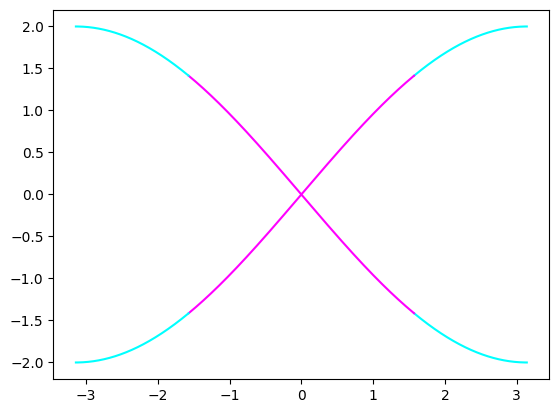

In [31]:
from itertools import cycle
from matplotlib.colors import Normalize
csfont = {'fontname':'Serif'}
colormap1 = plt.cm.cool
k_range1 = np.arange(-np.pi/2,np.pi/2,0.001)
k_range2 = np.arange(np.pi/2,np.pi,0.001)
k_range3 = np.arange(-np.pi/2,-np.pi,-0.001)
a,g=1,1e-10

plt.plot(k_range2,dispersionplus(k_range2,a,g),c='cyan')
plt.plot(k_range2,-dispersionplus(k_range2,a,g),c='cyan')
plt.plot(k_range1,dispersionmin(k_range1,a,g),c=color1)
plt.plot(k_range1,-dispersionmin(k_range1,a,g),c=color1)
plt.plot(k_range3,dispersionplus(k_range3,a,g),c='cyan')
plt.plot(k_range3,-dispersionplus(k_range3,a,g),c='cyan')    

#plt.colorbar(gamma_range)
#plt.xlim(0,np.pi/2)
#plt.xlabel(r'$k$',**csfont, size='15')
#plt.ylabel(r'$\epsilon_{\gamma}^{k}$',**csfont, size='15')
plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/Dispersion folding 1 a=1 g=0.pdf", bbox_inches='tight')  